#### 1. Selecting Dataset

The Home Mortgage Disclosure Act (HMDA) mandates that numerous financial institutions collect, report, and publicly share information regarding mortgage transactions. The data for the year 2023 was made available in March 2024, providing a valuable opportunity to examine an extensive dataset of mortgages that took place in the United States during that year. Source (HMDA: https://ffiec.cfpb.gov/).

A notable addition to the HMDA dataset is a boolean indicator that specifies whether the mortgage applicant is over the age of 62. While the age of the applicant has always been part of the dataset, this specific boolean piqued my interest. It raises the question of how the borrowing behaviors of older applicants, defined as those over 62, differ from those of younger applicants, who are under 62.

My hypothesis is that older applicants may be inclined to downsize their homes, which could result in lower property values for this demographic. Additionally, I suspect that these elder applicants might be utilizing the equity from their current homes when relocating, leading to lower loan amounts in comparison to their younger counterparts. We will initiate our data analysis by importing the necessary libraries and executing the download function.

In [8]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)  

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")       

In [10]:
import thinkstats2
import thinkplot
import numpy as np
import pandas as pd 

The dataset, referred to as the "Modified Loan/Application Register (LAR)," is contained within a text file that is compressed in a zip format. To effectively adjust the pd.read_csv() function for this dataset, I consulted the following resources: https://www.geeksforgeeks.org/reading-specific-columns-of-a-csv-file-using-pandas/ and https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options.

For further information, the Data Dictionary associated with HMDA can be accessed at: https://ffiec.cfpb.gov/documentation/publications/modified-lar/modified-lar-schema.

In [13]:
zf = 'https://s3.amazonaws.com/cfpb-hmda-public/prod/dynamic-data/combined-mlar/2023/header/2023_combined_mlar_header.zip'
df = pd.read_csv(zf, sep = '|', na_values = "NA", usecols=['activity_year', 'loan_purpose', 'occupancy_type','loan_amount', 
                'action_taken', 'applicant_sex', 'applicant_age', 'applicant_age_above_62', 'income', 
                'combined_loan_to_value_ratio', 'loan_term', 'property_value'],
                dtype={"activity_year": int, "loan_purpose": int, "occupancy_type": int, 
                      "loan_amount": int, "action_taken": int, "applicant_sex": int, "applicant_age": str, 
                      "applicant_age_above_62": str, "income": float,
                      "combined_loan_to_value_ratio": str, "loan_term": str, "property_value": str}) 

#### 2. Description of variables

- Activity Year: This value must be set to 2023 for all entries.
- Loan Purpose: We will restrict this to "1" to indicate Home Purchases exclusively
- Occupancy Type: This will be limited to "1" to signify Principal residence only, excluding second homes and investment properties.
- Loan Amount: The loan amount should be expressed in dollars, rounded to the nearest
- 10,000.
- Action Taken: Our primary focus will be on loans that were successfully completed and originated, designated as (1). Other statuses include Application denied (3) and Application withdrawn by applicant (4).
- Sex of Applicant: The coding will be as follows: 1 for Male, 2 for Female, 3 for Information not provided, 4 for NA, 5 is not used, and 6 for Both.
- Age of Applicant: Applicants will be categorized into age groups: >25, 25-34, 35-44, 45-54, 55-64, 65-74, and >75.
- Age of Applicant >= 62: This will be indicated with "Yes," "No," or "NA."
- Income: The applicant's income will be recorded in thousands of dollars ($K) or marked as NA if not applicable.
- Combined Loan to Value Ratio: This represents the total debt against the property compared to its value, typically a floating number, but may also include "NA" or "Exempt" values.

Some cleaning will be necessary to prepare this dataset for analysis, owing to certain binning strategies and "Exempt" values present in the data.

In [15]:
df

,activity_year,loan_purpose,occupancy_type,loan_amount,action_taken,applicant_sex,applicant_age,applicant_age_above_62,income,combined_loan_to_value_ratio,loan_term,property_value
0,2023,32,1,495000,5,1,45-54,No,155.0,NaN,360,NaN
1,2023,32,1,15000,3,2,45-54,No,28.0,53.489,360,215000
2,2023,32,1,205000,4,1,45-54,No,180.0,NaN,360,NaN
3,2023,32,1,195000,1,2,55-64,Yes,101.0,55.715,360,355000
4,2023,32,1,195000,1,2,45-54,No,72.0,52.055,360,365000
...,...,...,...,...,...,...,...,...,...,...,...,...
11555488,2023,31,1,65000,1,2,25-34,No,51.0,80.0,60,85000
11555489,2023,1,1,35000,1,2,45-54,No,72.0,27.27,60,145000
11555490,2023,31,1,85000,1,2,55-64,No,39.0,54.14,60,155000
11555491,2023,31,1,65000,1,2,45-54,No,81.0,46.85,60,145000


Filters
We will refine our selection to include only those mortgages designated for the purchase of principal residences. This adjustment decreases the overall record count to approximately 5.9 million.

Loan Purpose = 1 (Home purchases exclusively)
Occupancy Type = 1 (Principal residence exclusively)

In [17]:
df_filt = df[df['loan_purpose']==1]
df_filt = df_filt[df_filt['occupancy_type']==1]
df_filt

,activity_year,loan_purpose,occupancy_type,loan_amount,action_taken,applicant_sex,applicant_age,applicant_age_above_62,income,combined_loan_to_value_ratio,loan_term,property_value
5,2023,1,1,445000,4,1,25-34,No,198.0,NaN,360,NaN
17,2023,1,1,235000,1,3,45-54,No,89.0,96.5,360,245000
21,2023,1,1,415000,1,2,55-64,No,148.0,96.5,360,425000
30,2023,1,1,335000,4,1,55-64,No,188.0,NaN,360,NaN
32,2023,1,1,285000,1,2,45-54,No,131.0,80.0,360,355000
...,...,...,...,...,...,...,...,...,...,...,...,...
11555481,2023,1,1,225000,4,1,55-64,No,92.0,NaN,360,NaN
11555483,2023,1,1,85000,1,1,35-44,No,42.0,112.8,60,145000
11555484,2023,1,1,185000,1,1,45-54,No,149.0,93.0,60,285000
11555485,2023,1,1,45000,1,1,45-54,No,62.0,76.54,60,65000


#### 3. Stats and Histogram (5 Variables)

#### 3.1 Age Histogram   
Initially, we will examine the age distribution among mortgage applicants. Since the 'applicant_age' field is represented as a string rather than an integer, it is necessary to rearrange the dictionary generated by the thinkstats2.Hist() function. I will employ matplotlib's functionality to create the histogram instead of using textual representations, as it can effectively utilize the reordered dictionary.

In [19]:
age_filt = df_filt[df_filt['applicant_age']!= '8888']
hist = thinkstats2.Hist(age_filt.applicant_age, label='Age of Applicant')
sort_list = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74']
reordered_hist = {k: hist[k] for k in sort_list}
re_hist = thinkstats2.Hist(reordered_hist, label='Age of Applicant')

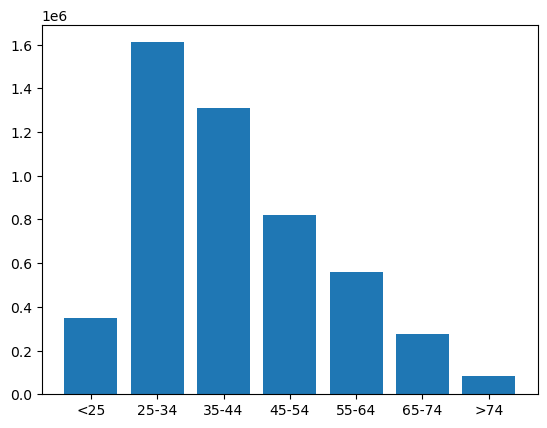

In [20]:
import matplotlib.pyplot as plt
plt.bar(range(len(reordered_hist)), list(reordered_hist.values()), align='center')
plt.xticks(range(len(reordered_hist)), list(reordered_hist.keys()))
plt.show()

This indicates that the predominant demographic for mortgage applications consists of individuals aged 25 to 34. It will be intriguing to observe whether this distribution shifts when analyzing mortgages that have been finalized and converted into originated loans. Given that the data has already been categorized, precise calculations of mean, variance, and other statistical measures are not feasible.

#### 3.2 Income Histogram.

The number of high income applicants make it difficult to set bin sizes, so I will set the range to 500000 and under. 

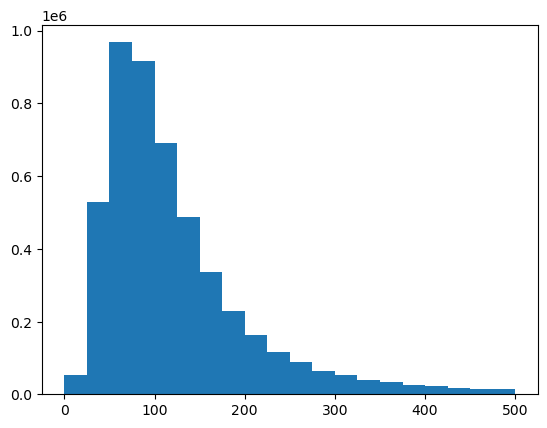

In [23]:
income_filt = age_filt[age_filt.income >0].copy(deep=True)
plt.hist(income_filt.income, bins=20, range=[0, 500])
plt.show()

In [24]:
print("Mean:", income_filt.income.mean(), 
      "Median:", income_filt.income.median(), 
      "mode:", income_filt.income.mode())
print("variance:", income_filt.income.var(), 
    "s.d.", income_filt.income.std())
print("Min:", income_filt.income.min(), 
      "Max:", income_filt.income.max(), 
      "Interquartile Range:", np.percentile(income_filt.income, 75)-np.percentile(income_filt.income, 25))
print("Q1:", np.percentile(income_filt.income, 25), 
      "Q3:", np.percentile(income_filt.income, 75) )

Mean: 139.99077336051346 Median: 100.0 mode: 0    60.0
Name: income, dtype: float64
variance: 5991882.959464635 s.d. 2447.8322980679527
Min: 1.0 Max: 5004153.0 Interquartile Range: 87.0
Q1: 67.0 Q3: 154.0


It is anticipated that the mean income of 140,000 will exceed the median income, as the presence of several exceptionally high incomes influences the mean upward. In this context, the median income of 100,000 serves as a more reliable measure of central tendency. Notably, there is a maximum reported income of 5 billion, which is probably a typographical error. The first and third quartiles provide insight into the distribution of incomes. Consistent with the visual representation observed in the histogram, the interquartile range is identified as spanning from 67,000 to 154,000.

#### 3.3 Loan Term Histogram.

A highly effective method for examining the most sought-after loan terms is by utilizing a "top 10" histogram.

Initially, it is essential to eliminate the "Exempt" values from consideration. The 360-month (30-year) mortgage stands out as the most favored option, with the 25-year and 15-year mortgages following in popularity.

<Axes: xlabel='loan_term'>

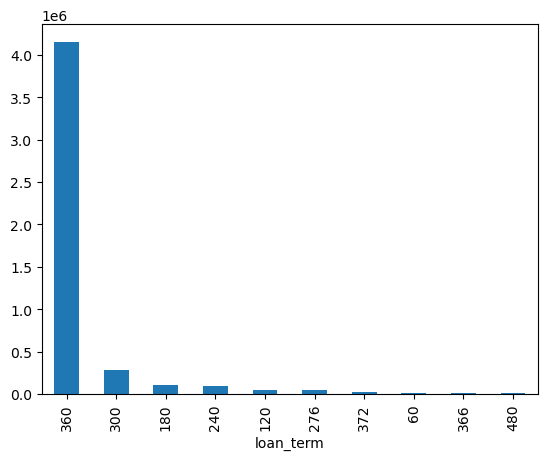

In [27]:
term_filt = income_filt[income_filt.loan_term != "Exempt"]
top_terms = (term_filt['loan_term'].value_counts()).iloc[:10]
top_terms.plot(kind='bar')

#### 3.4 Gender Histogram

The histogram code from *Think Stats* can be utilized for this particular task.

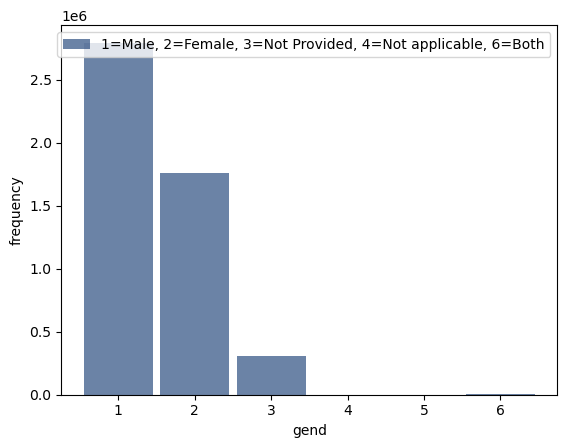

Hist({1: 2793026, 2: 1758181, 3: 310649, 6: 2762, 4: 1236}, '1=Male, 2=Female, 3=Not Provided, 4=Not applicable, 6=Both')

<Figure size 800x600 with 0 Axes>

In [29]:
hist_gend = thinkstats2.Hist(term_filt.applicant_sex, label = 
'1=Male, 2=Female, 3=Not Provided, 4=Not applicable, 6=Both')
thinkplot.Hist(hist_gend)
thinkplot.Show(xlabel = 'gend', ylabel = 'frequency')
hist_gend

The data indicates a significantly higher number of male applicants compared to female applicants. It appears that the information we are analyzing reflects the 'first applicant' listed on each application, suggesting a possible inclination for males to position their names at the forefront. However, to thoroughly investigate this hypothesis, it would be necessary to incorporate additional data from the table.

#### 3.5 Loan Ammount

The final variable we will examine is the Loan Amount. In a manner akin to our analysis of Income, it is essential to establish a range due to the high costs associated with applications at the upper limit. We will restrict our focus to loans that are less than $1 million, as this will provide a comprehensive understanding of the data's distribution. The histogram code from Think Stats will be utilized for this purpose.

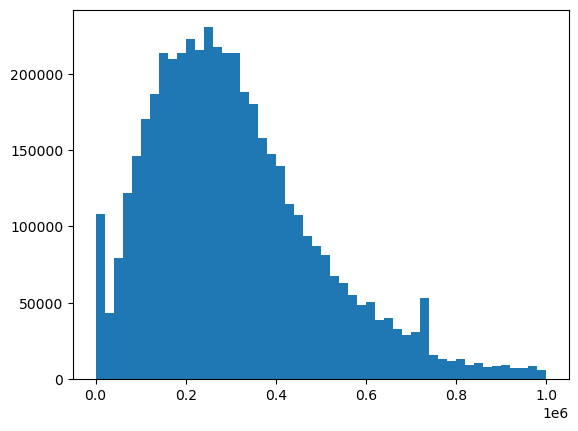

In [32]:
hist_loan = thinkstats2.Hist(term_filt.loan_amount, label = 'Loan Amount')
plt.hist(term_filt.loan_amount, bins=50, range=[0, 1000000])
plt.show()

In [33]:
print("mean:", term_filt.loan_amount.mean(), "median:", term_filt.loan_amount.median(), 
      "mode:", term_filt.loan_amount.mode())
print("variance:", term_filt.loan_amount.var(), "s.d.", term_filt.loan_amount.std())
print("Min:", term_filt.loan_amount.min(), "Max:", term_filt.loan_amount.max(), 
      "Interquartile Range:", np.percentile(term_filt.loan_amount, 75)-
       np.percentile(term_filt.loan_amount, 25))
print("Q1:", np.percentile(term_filt.loan_amount, 25), "Q3:", 
      np.percentile(term_filt.loan_amount, 75) )

mean: 341400.0892751817 median: 285000.0 mode: 0    205000
Name: loan_amount, dtype: int32
variance: 149845257113.42218 s.d. 387098.51086438214
Min: 5000 Max: 290905000 Interquartile Range: 250000.0
Q1: 175000.0 Q3: 425000.0


The loan amounts, much like income figures, reveal a long tail to the right, leading to a mean of 341,000. The median, which stands at 285,000, is a more suitable indicator of central tendency. There is a substantial degree of variance, with the standard deviation exceeding 387,000. The smallest loan amount recorded is 5,000, while the largest is an impressive $291 million. Furthermore, 50% of the loans fall within the range of 175,000 to 425,000.

A notable increase is observed at the far left end, suggesting a preference for very small mortgage loans. This finding may warrant further investigation in subsequent analyses. It is possible that a tax incentive associated with these mortgages enhances their appeal, even for minimal amounts.

Additionally, there is a significant peak around loan amounts of 750,000. This figure coincides with the threshold for mortgage interest deduction, indicating that it is a favored loan amount among borrowers.

#### 4. PMF Comparison

The subsequent task involves comparing the Probability Mass Function (PMF) for a variable across two distinct scenarios. The second histogram I created examined the income ranges of individuals who applied for mortgages. In this analysis, I aimed to determine whether the distribution varies when considering mortgages that were ultimately completed (originated loans). *The textbook for this course recommended to use the following code:*

In [36]:
income_filt["income_round"] = round(income_filt.income, -1)
orig_filt = income_filt[income_filt.action_taken == 1]
incomplete_filt = income_filt[income_filt.action_taken != 1]

orig_pmf = thinkstats2.Pmf(orig_filt.income_round, label = "loan originated")
incomplete_pmf = thinkstats2.Pmf(incomplete_filt.income_round, label = "incomplete application")

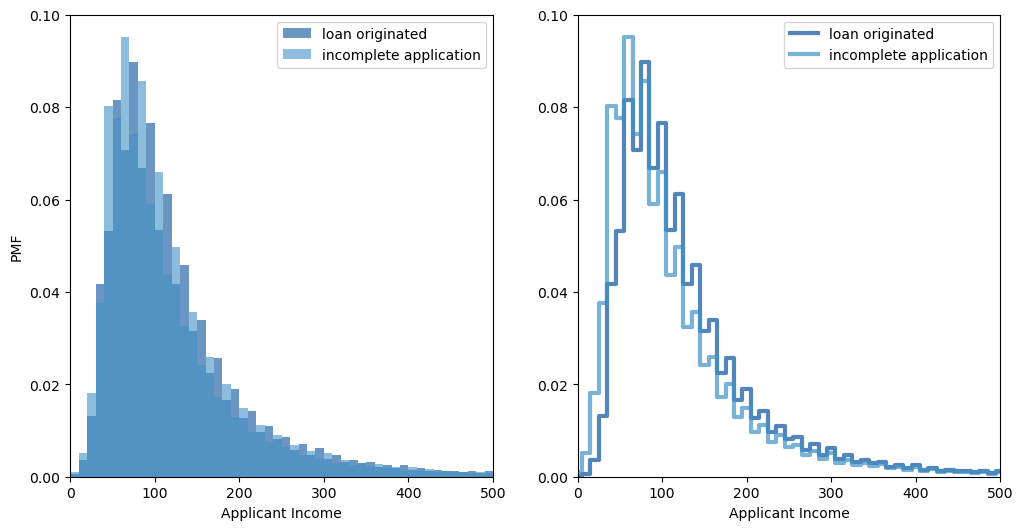

In [37]:
width = 10
axis = [0, 500, 0, 0.1]
thinkplot.PrePlot(2, cols=2)
thinkplot.Hist(orig_pmf, align="right", width=width)
thinkplot.Hist(incomplete_pmf, align="left", width=width)
thinkplot.Config(xlabel="Applicant Income", ylabel="PMF", axis=axis)

thinkplot.PrePlot(2)
thinkplot.SubPlot(2)
thinkplot.Pmfs([orig_pmf, incomplete_pmf])
thinkplot.Config(xlabel="Applicant Income", axis=axis)

Analyzing the two probability mass functions (PMFs) presented together reveals a pattern that aligns with our expectations. Applicants with higher income levels tend to have a greater proportion of applications that successfully progress to loan origination. In contrast, those with lower incomes exhibit a relatively larger segment of applications that do not complete the process for various reasons. One potential factor leading to the rejection of an application could be a high debt-to-income ratio. Consequently, it is reasonable to anticipate that individuals with lower incomes would experience a higher rate of application denials.

#### 5. Load Amount (CDF)

I will now commence the examination of the question at hand: do loan amounts vary for elderly applicants?
I will utilize our "orig_filt" dataset, as it includes the applications that led to originated loans. The axis will be adjusted to focus on loans under $1 million due to the presence of a long tail. Initially, we will examine the complete population of originated loans. The code suggested by "Think Stats" will be employed consistently throughout for this analysis:


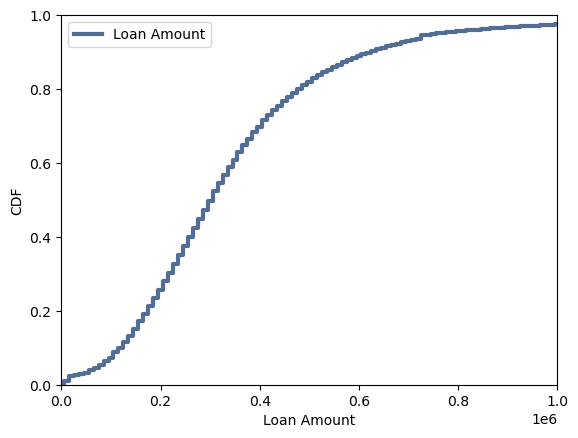

<Figure size 800x600 with 0 Axes>

In [40]:
all_loans_CDF = thinkstats2.Cdf(orig_filt.loan_amount, label='Loan Amount')
axis = [0, 1000000, 0, 1]
thinkplot.Cdf(all_loans_CDF)
thinkplot.Show(xlabel= 'Loan Amount', ylabel='CDF', axis=axis)

The visual representation seems accurate. It indicates that the median value for loans is approximately 300,000, which corresponds with the histogram of all loan applications we previously analyzed, where the median was recorded at 285,000. Next, we will examine the cumulative distribution function (CDF) for applicants aged over 62 in comparison to those who are younger.

In [42]:
elder_filt = orig_filt[orig_filt.applicant_age_above_62 == "Yes"].copy(deep=True)
younger_filt = orig_filt[orig_filt.applicant_age_above_62 == "No"].copy(deep=True)
elder_cdf = thinkstats2.Cdf(elder_filt.loan_amount, label='Elder')
younger_cdf = thinkstats2.Cdf(younger_filt.loan_amount, label='Younger')

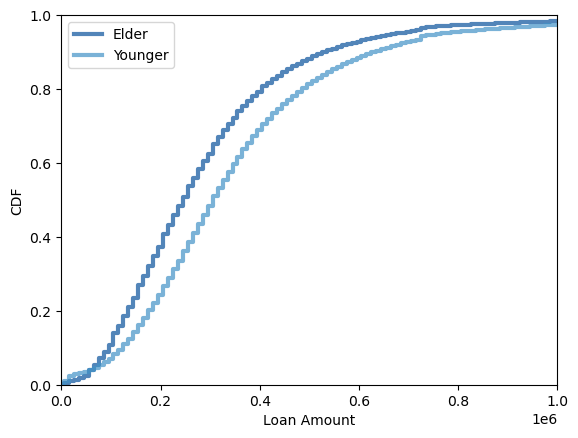

<Figure size 800x600 with 0 Axes>

In [43]:
thinkplot.PrePlot(2)
thinkplot.Cdfs([elder_cdf, younger_cdf])
thinkplot.Show(xlabel='Loan Amount', ylabel='CDF', axis=axis)

It is evident that older applicants tend to seek smaller loan amounts compared to their younger counterparts. Data indicates that approximately 40% of mortgages taken out by elderly individuals are for amounts under $200,000, whereas this figure drops to around 20% for younger borrowers. This trend raises important questions about the underlying factors influencing these choices.

One potential explanation worth investigating is whether the smaller loan amounts for older applicants are a result of purchasing less expensive homes or if they are able to make larger down payments. It is plausible that many elderly individuals are selling their previous homes and utilizing the equity gained to finance their new purchases, a scenario less common among younger applicants who may not have built up significant equity. To further explore this hypothesis, we will analyze cumulative distribution functions (CDFs) related to property values, ensuring to exclude any loans categorized as "exempt" or "na" for accurate results.

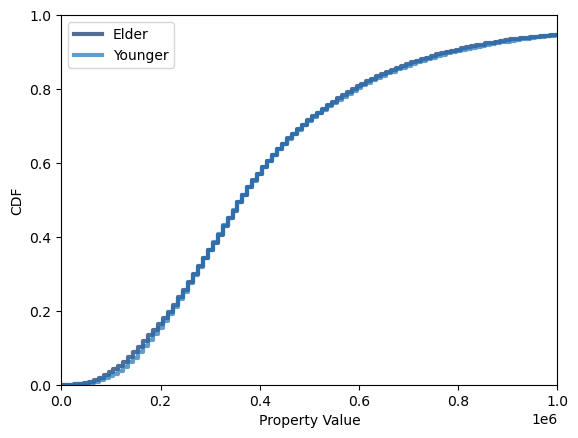

<Figure size 800x600 with 0 Axes>

In [45]:
prop_filt = orig_filt[orig_filt.property_value != "Exempt"].copy(deep=True)
prop_filt = prop_filt[prop_filt.property_value.isnull() == False].copy(deep=True)
prop_filt["prop_int"] = prop_filt["property_value"].astype(int)

elder_prop_filt = prop_filt[prop_filt.applicant_age_above_62 == "Yes"].copy(deep=True)
younger_prop_filt = prop_filt[prop_filt.applicant_age_above_62 == "No"].copy(deep=True)
elder_prop_cdf = thinkstats2.Cdf(elder_prop_filt.prop_int, label='Elder')
younger_prop_cdf = thinkstats2.Cdf(younger_prop_filt.prop_int, label='Younger')

thinkplot.Cdfs([elder_prop_cdf, younger_prop_cdf])
thinkplot.Show(xlabel='Property Value', ylabel='CDF', axis=axis)

The cumulative distribution function (CDF) for property values indicates minimal variation between older and younger applicants. While it is evident that elderly applicants secure smaller loans, they do not typically purchase homes of lesser value. This trend may be attributed to their propensity to make larger down payments on the properties they acquire.

A marginal distinction is observed in the case of homes priced below $200,000, where the CDF for elderly applicants is slightly elevated compared to that of younger applicants. Conducting a hypothesis test could provide insights into whether this observed difference is statistically significant.

#### 6. Analytical Distribution

The property values seem to follow a normal distribution pattern. I will begin by attempting to apply a normal model to this data. It appears that the values of the properties are distributed in a manner consistent with a normal distribution. My initial approach will be to fit a normal model to this dataset.

In [48]:
print("mean:", prop_filt.prop_int.mean(), "median:", prop_filt.prop_int.median())
print("variance:", prop_filt.prop_int.var(), "s.d.", prop_filt.prop_int.std())

mean: 455699.93576583837 median: 365000.0
variance: 178166430568.48508 s.d. 422097.6552511102


By utilizing the functions provided in the Think Stats text, we can create a visual representation of a normal distribution that reflects the mean and standard deviation derived from the actual dataset. Although the author's function is designed to eliminate certain outliers, the presence of a significant right tail in this dataset suggests that this approach may not adequately address all anomalies.

The application of the Think Stats functions allows us to generate a normal distribution plot informed by the actual data's mean and standard deviation. While the author's method does attempt to remove some outliers, the considerable right tail observed in the dataset indicates that this strategy might fall short in effectively managing the data's irregularities.

Mean, Var 433147.2090859676 77665285528.59781
Sigma 278684.9216025112


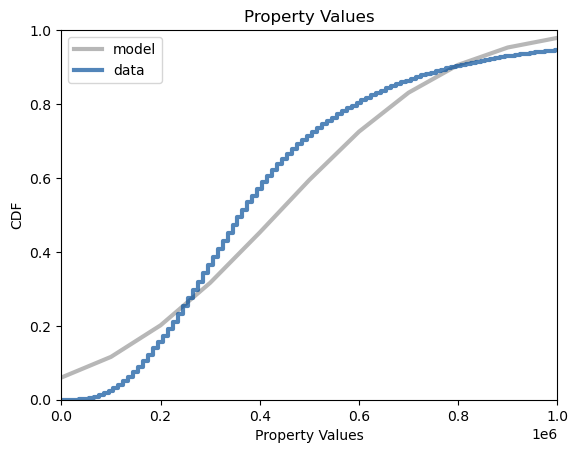

In [50]:
prop_val = prop_filt.prop_int
# Estimating parameters with the exclusion of outliers results in a 
# more accurate fit.
mu, var = thinkstats2.TrimmedMeanVar(prop_val, p=0.01)
print("Mean, Var", mu, var)

# plot the model
sigma = np.sqrt(var)
print("Sigma", sigma)
xs, ps = thinkstats2.RenderNormalCdf(mu, sigma, low=0, high=10000000)

thinkplot.Plot(xs, ps, label="model", color="0.6")

# plot the data
cdf = thinkstats2.Cdf(prop_val, label="data")

thinkplot.PrePlot(1)
thinkplot.Cdf(cdf)
thinkplot.Config(title="Property Values", xlabel="Property Values", 
                 ylabel="CDF", axis = axis)

The standard model demonstrates a good fit up to approximately two standard deviations from the mean. Beyond this point, however, it fails to accurately represent the higher values of large houses in the right tail of the dataset. To address this issue, we will explore the application of a log-normal model to determine if it enhances the overall fit.

In [52]:
def MakeNormalModel(prop_val):
    """Plots a CDF with a Normal model.
    weights: sequence
    """
    cdf = thinkstats2.Cdf(prop_val, label="property value")
    mean, var = thinkstats2.TrimmedMeanVar(prop_val)
    std = np.sqrt(var)
    print("n, mean, std", len(prop_val), mean, std)
    xmin = mean - 4 * std
    xmax = mean + 4 * std
    xs, ps = thinkstats2.RenderNormalCdf(mean, std, xmin, xmax)
    thinkplot.Plot(xs, ps, label="model", linewidth=4, color="0.8")
    thinkplot.Cdf(cdf)

n, mean, std 2954814 5.56211263511076 0.2530085792429604


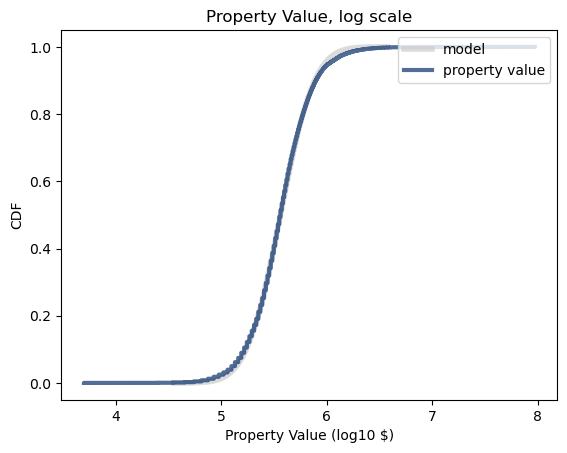

In [53]:
log_prop = np.log10(prop_val)
MakeNormalModel(log_prop)
thinkplot.Config(
    title="Property Value, log scale",
    xlabel="Property Value (log10 $)",
    ylabel="CDF",
    loc="upper right",
)

The Log-normal model aligns with the data significantly better.

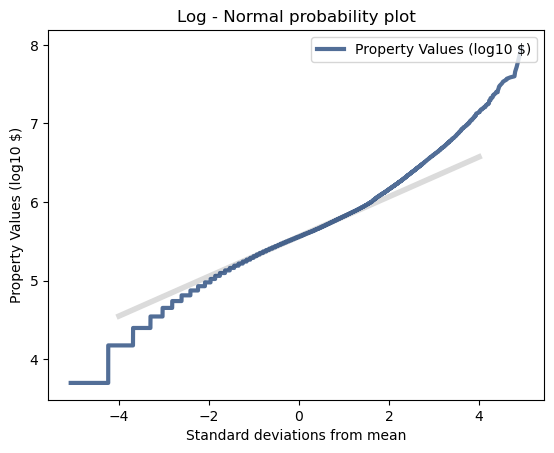

In [76]:
mean, var = thinkstats2.TrimmedMeanVar(log_prop, p=0.01)
std = np.sqrt(var)
xs = [-4, 4]
fxs, fys = thinkstats2.FitLine(xs, mean, std)
thinkplot.Plot(fxs, fys, linewidth=4, color="0.8")
xs, ys = thinkstats2.NormalProbability(log_prop)
thinkplot.Plot(xs, ys, label="Property Values (log10 $)")
thinkplot.Config(
    title="Log - Normal probability plot",
    xlabel="Standard deviations from mean",
    ylabel="Property Values (log10 $)",
)

#### 7. Correlations & ScatterPlots

In the exploration of this hypotheses, we have observed that older applicants generally opt for smaller mortgage amounts, while the disparity in the value of the properties they purchase is not as pronounced. At this juncture, we aim to delve deeper into the connection between the applicants' ages and the mortgages they secure. This analysis will allow us to better understand how age influences borrowing behavior in the context of mortgage applications.

Initially, we will examine what appears to be a significant correlation between the age of the applicants and the value of the loans they acquire. Following that, we will assess the relationship between the applicants' ages and their willingness to incur debt. The dataset includes a "loan to value" ratio, which suggests that younger applicants are likely to take out larger loans relative to the property value when compared to their older counterparts.

In our previous cumulative distribution function (CDF) analysis, we categorized age into a binary format (older or younger than 62). To effectively analyze correlations, it is essential to convert these age categories into a more continuous scale. We will utilize seven age brackets for applicants, assigning them values from 0 to 6, which can be interpreted as "decades from age 15." For instance, a 24-year-old applicant would fall into the 'age_bin' category of 0, indicating they are less than a decade away from the age of 15.

Source: Source: https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/)

In [79]:
# New dataframe that includes "age bins" ranging from zero to six.

age_bins = prop_filt.copy(deep=True)
conditions = [
    (age_bins["applicant_age"] == "<25"),
    (age_bins["applicant_age"] == "25-34"),
    (age_bins["applicant_age"] == "35-44"),
    (age_bins["applicant_age"] == "45-54"),
    (age_bins["applicant_age"] == "55-64"),
    (age_bins["applicant_age"] == "65-74"),
    (age_bins["applicant_age"] == ">74")
    ]
values = [0, 1, 2, 3, 4, 5, 6]
age_bins["age_bin"] = np.select(conditions, values)
age_bins.head()

,activity_year,loan_purpose,occupancy_type,loan_amount,action_taken,applicant_sex,applicant_age,applicant_age_above_62,income,combined_loan_to_value_ratio,loan_term,property_value,income_round,prop_int,age_bin
17,2023,1,1,235000,1,3,45-54,No,89.0,96.5,360,245000,90.0,245000,3
21,2023,1,1,415000,1,2,55-64,No,148.0,96.5,360,425000,150.0,425000,4
32,2023,1,1,285000,1,2,45-54,No,131.0,80.0,360,355000,130.0,355000,3
33,2023,1,1,205000,1,2,35-44,No,194.0,95.0,360,215000,190.0,215000,2
39,2023,1,1,305000,1,3,45-54,No,91.0,96.5,360,315000,90.0,315000,3


Age and Loan Value Analysis

We will proceed to utilize the suggested code from the text to sample and introduce jitter to the data across the bin intervals. Given the substantial size of the dataset, we will examine both a scatter plot and a hexbin plot. Modifications will be made to the code recommended by Think Stats.

In [82]:
sample = thinkstats2.SampleRows(age_bins, 5000)
loan_values, ages = sample.loan_amount, sample.age_bin
def Jitter(values, jitter =0.5):
    n = len(values)
    return np.random.uniform(-jitter, +jitter, n) + values
ages= Jitter(ages, .5)
loan_values = Jitter(loan_values, 500)

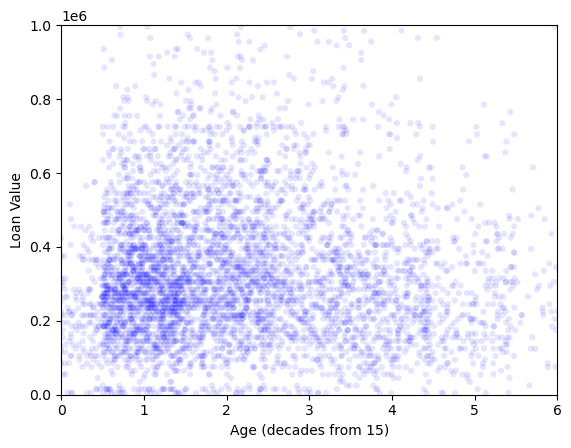

In [84]:
thinkplot.Scatter(ages, loan_values, alpha=0.1, s=20)
thinkplot.Config(xlabel='Age (decades from 15)',
                 ylabel='Loan Value',
                 axis=[0, 6, 0, 1000000],
                 legend=False)

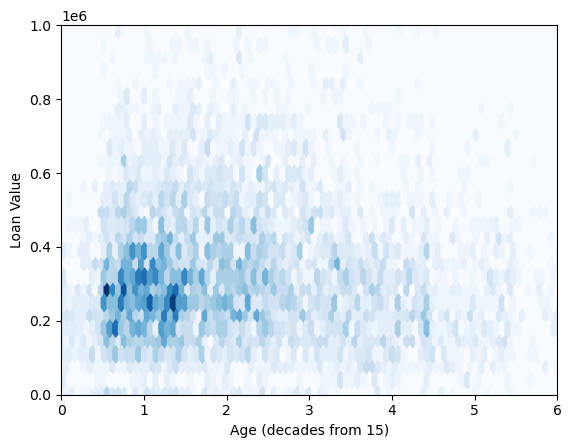

In [86]:
thinkplot.HexBin(ages, loan_values)
thinkplot.Config(xlabel='Age (decades from 15)',
                 ylabel='Loan Value',
                 axis=[0, 6, 0, 1000000],
                 legend=False)

Analysis

Given this information, identifying the anticipated relationship proves challenging. It appears that loan values may experience a slight increase as individuals transition from their 20s into their 30s, 40s, and 50s, before declining again in the subsequent decades. If this pattern holds true, the regression models we will apply later could be the most appropriate, as this relationship may exhibit non-linear characteristics. We will utilize the code from the Think Stats text for our correlation analysis.

In [88]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)
    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

In [90]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)
    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

In [94]:
Cov(age_bins.loan_amount, age_bins.age_bin)

10312.705751221018

In [96]:
Corr(age_bins.loan_amount, age_bins.age_bin)

0.0261574212430717

The variance and Pearson's Correlation coefficient suggest a positive relationship between age and loan amount. The Pearson's Correlation value of .026 signifies that this correlation is minimal. Observations indicate a potential negative association between age and loan value among older individuals, which may be counterbalanced by a positive relationship in younger age groups. This points to a non-linear relationship that warrants further investigation in our regression analysis.

Loan-to-Value vs Age Ratio

As we are utilizing the "combined_loan_to_value_ratio" for the first time, it is essential to eliminate the "exempt" and "NA" entries. After removing these string values from the dataset, we will proceed to convert the field to a numeric format.

In [100]:
LTV_filt = age_bins[age_bins.combined_loan_to_value_ratio != "Exempt"].copy(deep=True)
LTV_filt = LTV_filt[LTV_filt.combined_loan_to_value_ratio.isnull() == False].copy(deep=True)
LTV_filt["LTV_float"] = pd.to_numeric(LTV_filt.combined_loan_to_value_ratio, errors='coerce')
sample = thinkstats2.SampleRows(LTV_filt, 5000)
LTV, ages = sample.LTV_float, sample.age_bin
ages= Jitter(ages, .5)

In [102]:
print("Min:", LTV_filt.LTV_float.min(), "Max:", LTV_filt.LTV_float.max())

Min: 0.112 Max: 2075.412


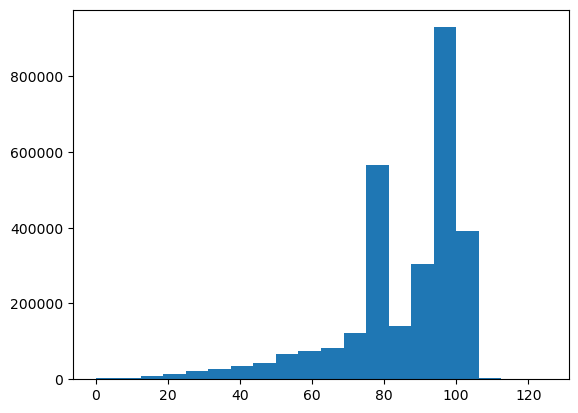

In [104]:
plt.hist(LTV_filt.LTV_float, bins=20, range=[0, 125])
plt.show()

The statistics indicate that the most common loan-to-value (LTV) ratios are approximately 80% and around 100%. The 80% figure is particularly relevant, as it represents the threshold for private mortgage insurance (PMI) in Ohio. Additionally, there are instances where properties are financed at levels exceeding their actual value. Notably, the maximum LTV ratio suggests that there is at least one property with a mortgage amounting to 20 times its value, which may be an error.

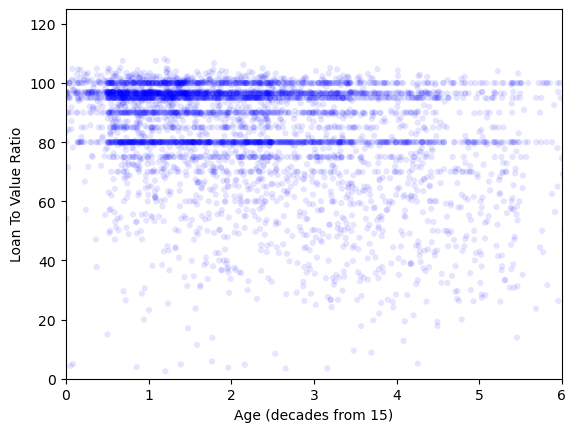

In [107]:
thinkplot.Scatter(ages, LTV, alpha=0.1, s=20)
thinkplot.Config(xlabel='Age (decades from 15)',
                 ylabel='Loan To Value Ratio',
                 axis=[0, 6, 0, 125],
                 legend=False)

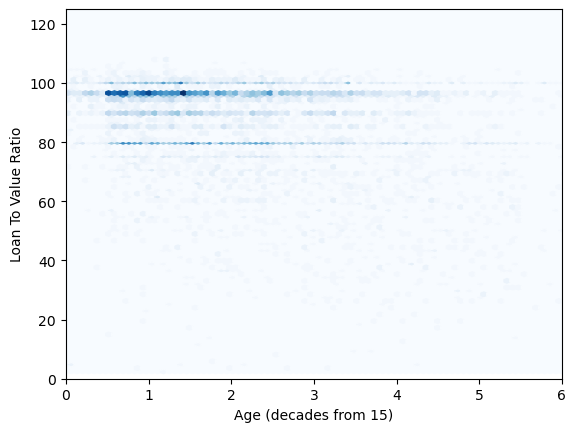

In [109]:
thinkplot.HexBin(ages, LTV)
thinkplot.Config(xlabel='Age (decades from 15)',
                 ylabel='Loan To Value Ratio',
                 axis=[0, 6, 0, 125],
                 legend=False)

The scatterplot suggests that younger applicants tend to have loan-to-value (LTV) ratios exceeding 100, while older applicants generally exhibit lower LTV ratios. Although this trend is subtle, particularly in light of the prevalence of mortgages with LTVs of 80%, 90%, 95%, and 100%, there is a discernible pattern where the lighter dots seem to move from the upper left to the lower right.

In [112]:
Cov(LTV_filt.LTV_float, LTV_filt.age_bin)

-7.49425510746495

In [114]:
Corr(LTV_filt.LTV_float, LTV_filt.age_bin)

-0.3158005113294617

#### 8. Hypothesis Test

During our analysis of the cumulative distribution function (CDF) for property values, we noted an intriguing finding: the CDFs for older and younger applicants were nearly indistinguishable, with only a minor variation at the lower end of the property value spectrum. This raises the question of whether the slight discrepancy observed in the CDFs for these two age groups is statistically significant. To investigate this, we will conduct a difference in means test, focusing specifically on properties valued at $300,000 or less, as this is the range where we identified the divergence. It stands to reason that beyond a certain property value, the financial status of the applicant may diminish the impact of age on their home-buying decisions.

In [117]:
Sub300_elder_filt = elder_prop_filt[elder_prop_filt.prop_int < 300000].copy(deep=True)
Sub300_younger_filt = younger_prop_filt[younger_prop_filt.prop_int < 300000].copy(deep=True)
print(Sub300_elder_filt.prop_int.mean(), Sub300_younger_filt.prop_int.mean())

201104.64110694724 206637.01672658478


The calculated difference in means amounts to approximately $5500, which serves as our test statistic. The null hypothesis posits that this observed difference is not a genuine effect. Next, we will incorporate the code for hypothesis testing from the Think Stats text.

In [120]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()
        
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [137]:
# Creating the data frames
data = Sub300_elder_filt.prop_int, Sub300_younger_filt.prop_int
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.0

In [138]:
# A p-value of 0 indicates that we should dismiss the null hypothesis. 
# To ensure accuracy, I will apply the scipy formula to calculate a 
# more precise p-value.

from scipy import stats
t_stat, p_value = stats.ttest_ind(Sub300_elder_filt.prop_int, Sub300_younger_filt.prop_int)
print("p_value:", p_value)

p_value: 9.95867706509536e-161


This approach allows us to clearly observe the low value of the p-value. With this information, we can conclude that the difference in means has a statistically significant effect, despite being relatively small.

#### 9. Regression 

In our analysis of correlation, we observed that the connection between age and loan value did not exhibit a linear pattern. It was hypothesized that loan values could increase during the earlier decades and subsequently decline in the later decades. This observation indicates that a quadratic model may be more appropriate for capturing the relationship. Initially, we will implement a linear model to establish a baseline for comparison.

We will establish our significance threshold (alpha) at the conventional level of 0.05, meaning that any p-values falling below this threshold will be deemed significant. This approach will allow us to evaluate the effectiveness of the linear model before exploring more complex modeling options that may better represent the underlying relationship between age and loan value.

In [133]:
import statsmodels.formula.api as smf
formula = 'loan_amount ~ age_bin'
results = smf.ols(formula, data=age_bins).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            loan_amount   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2023.
Date:                Sun, 17 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:04:57   Log-Likelihood:            -4.1298e+07
No. Observations:             2954814   AIC:                         8.260e+07
Df Residuals:                 2954812   BIC:                         8.260e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.443e+05    303.596   1134.057      0.000    3.44e+05    3.45e+05
age_bin     5365.5293    119.290     44.979      0.000    5131.725    5599.333
==============================================================================
Omnibus:                  3887380.982   Durbin-Watson:                   1.590
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4423835989.505
Skew:                           6.781   Prob(JB):                         0.00
Kurtosis:                     192.071   Cond. No.                         5.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Analysis

The analysis from our linear model indicates that the age_bin variable has a P-value of 0.0, which suggests a significant correlation. Nevertheless, the R-Squared value is notably low at 0.001, indicating that the applicant's age accounts for only a minimal portion of the variations in loan_amount. Moving forward, we will incorporate a quadratic variable into our model to enhance its explanatory power.

In [141]:
age_bins["age_bin2"] = age_bins.age_bin**2


formula = 'loan_amount ~ age_bin + age_bin2'
results = smf.ols(formula, data=age_bins).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            loan_amount   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                 4.007e+04
Date:                Sun, 17 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:07:07   Log-Likelihood:            -4.1260e+07
No. Observations:             2954814   AIC:                         8.252e+07
Df Residuals:                 2954811   BIC:                         8.252e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.492e+05    453.547    549.377      0.000    2.48e+05     2.5e+05
age_bin     1.112e+05    396.668    280.347      0.000     1.1e+05    1.12e+05
age_bin2   -2.019e+04     72.253   -279.414      0.000   -2.03e+04      -2e+04
==============================================================================
Omnibus:                  3931132.541   Durbin-Watson:                   1.602
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4833521105.679
Skew:                           6.911   Prob(JB):                         0.00
Kurtosis:                     200.657   Cond. No.                         37.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Analysis

The p-value continues to remain below our established threshold, and there has been an improvement in the R-squared value. Currently, our model explains 2.6% of the variability associated with loan_amount.

The coefficients align with our initial hypothesis regarding the nature of the relationship. The coefficient for age_bin is positive, while age_bin2 has a negative coefficient. This indicates that for younger individuals, the combined coefficients will lead to an increase in loan_amount as age progresses. However, there will come a point when the negative influence of age_bin2 will outweigh the positive effect of age_bin, resulting in a decrease in the estimated loan_amount as age continues to increase. This model effectively captures the anticipated "rise then fall" trend.

We have successfully illustrated the expected relationship between age and loan_amount. Nevertheless, it is important to note that this model accounts for only a small fraction of the variability in loan_amount. To enhance our exploratory data analysis, we should consider incorporating an additional variable that we previously examined: income. We will explore both linear and quadratic models for income, as a non-linear approach may be appropriate. This is due to the likelihood that low-income applicants tend to borrow less, while high-income applicants may not require substantial loans, suggesting a similar rise and fall pattern in the relationship with income as we observed with age.

In [143]:
formula = 'loan_amount ~ age_bin + age_bin2 + income'
results = smf.ols(formula, data=age_bins).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            loan_amount   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                 1.640e+05
Date:                Sun, 17 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:07:11   Log-Likelihood:            -4.1072e+07
No. Observations:             2954814   AIC:                         8.214e+07
Df Residuals:                 2954810   BIC:                         8.214e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.242e+05    427.409    524.553      0.000    2.23e+05    2.25e+05
age_bin     9.594e+04    372.994    257.208      0.000    9.52e+04    9.67e+04
age_bin2   -1.766e+04     67.916   -259.957      0.000   -1.78e+04   -1.75e+04
income       286.8318      0.453    633.265      0.000     285.944     287.720
==============================================================================
Omnibus:                  5075998.882   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    1591521159622.248
Skew:                         -10.080   Prob(JB):                         0.00
Kurtosis:                    3598.340   Cond. No.                     1.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [145]:
age_bins["income2"] = age_bins.income**2
formula = 'loan_amount ~ age_bin + age_bin2 + income + income2'
results = smf.ols(formula, data=age_bins).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            loan_amount   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                 2.899e+05
Date:                Sun, 17 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:09:33   Log-Likelihood:            -4.0810e+07
No. Observations:             2954814   AIC:                         8.162e+07
Df Residuals:                 2954809   BIC:                         8.162e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.919e+05    393.514    487.697      0.000    1.91e+05    1.93e+05
age_bin     7.668e+04    342.337    224.000      0.000     7.6e+04    7.74e+04
age_bin2   -1.445e+04     62.306   -231.896      0.000   -1.46e+04   -1.43e+04
income       656.3799      0.641   1024.534      0.000     655.124     657.636
income2       -0.0030   4.01e-06   -756.572      0.000      -0.003      -0.003
==============================================================================
Omnibus:                  3059627.325   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     106476991054.849
Skew:                          -3.435   Prob(JB):                         0.00
Kurtosis:                     932.944   Cond. No.                     1.95e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.95e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Analysis

As anticipated, the integration of income into the model significantly enhanced its performance, with the R-squared value increasing to 14%. The addition of squared income as a variable further refined the model, which now explains around 28% of the variability in loan_amount. The low P-values for all variables suggest strong correlations with loan_amount.

The coefficients associated with income and its square validate our theory of a rise-and-fall dynamic akin to age. Initially, the positive coefficient for 'income' elevates the predicted loan_amount as income rises. However, once the squared income becomes sufficiently large, its negative coefficient begins to diminish the positive effect of 'income', resulting in a reduction in loan_amount.